In [1]:
from pysqlite2 import dbapi2 as sql
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
db = "/home/eric/Documents/franklin/narsc2018/generated_data/narsc18.sqlite"
con = sql.connect(db)
con.enable_load_extension(True)
con.execute("SELECT load_extension('mod_spatialite');")

qry = '''
SELECT 
A.CL8AA1990 AS pop90,
A.CL8AA2000 AS pop00,
A.CL8AA2010 AS pop10,
B.*
FROM nhgis_pop_race_norm_90_10 AS A
JOIN county_specialization AS B
    ON A.GISJOIN = B.GISJOIN
;
'''

df = pd.read_sql(qry, con, index_col='GISJOIN')
con.close()
len(df)

3143

In [5]:
df.columns

Index([u'pop90', u'pop00', u'pop10', u'Sus_10', u'Sstate_10', u'Sus_00',
       u'Sstate_00', u'Sus_90', u'Sstate_90', u'ppctchg_0010', u'ppctchg_9000',
       u'growth_cat', u'growth_cat_90s'],
      dtype='object')

In [3]:
# create categories for pop change 2000 to 2010
# calc pop change in each decade
df['ppctchg_0010'] = ( df['pop10'] - df['pop00'] ) * 1.0 / df['pop00'] * 100
df['ppctchg_9000'] = ( df['pop00'] - df['pop90'] ) * 1.0 / df['pop90'] * 100
# growth categories 2000-2010
df['growth_cat'] = 0
df.loc[df['ppctchg_0010'] >= 5, 'growth_cat'] = 'growing'
df.loc[(df['ppctchg_0010'] < 5) & (df['ppctchg_0010'] >= 0 ), 'growth_cat'] = 'stable'
df.loc[df['ppctchg_0010'] < 0, 'growth_cat'] = 'shrinking'
# growth categories 1990-2000
df['growth_cat_90s'] = 0
df.loc[df['ppctchg_9000'] >= 5, 'growth_cat_90s'] = 'growing'
df.loc[(df['ppctchg_9000'] < 5) & (df['ppctchg_9000'] >= 0 ), 'growth_cat_90s'] = 'stable'
df.loc[df['ppctchg_9000'] < 0, 'growth_cat_90s'] = 'shrinking'
# xtab counties between 1990s and 2000s in terms of pop change category
pd.crosstab(df['growth_cat_90s'], df['growth_cat'], margins=True)

growth_cat,growing,shrinking,stable,All
growth_cat_90s,,,,
growing,1196,293,458,1947
shrinking,47,536,100,683
stable,57,272,184,513
All,1300,1101,742,3143


In [12]:
periods = [ ['90', '00'], ['00', '10'] ]
benchmarks = ['us', 'state']

for p in periods:
    start = p[0]
    end = p[1]
    for b in benchmarks:
        df['S_{}_diff_{}{}'.format(b,start,end)] = df['S{}_{}'.format(b, end)] - df['S{}_{}'.format(b, start)]

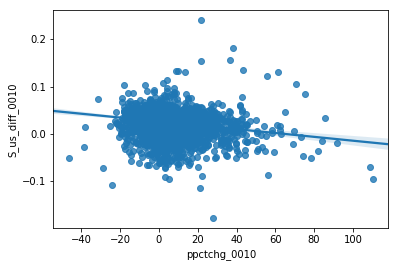

In [13]:
sns.regplot('ppctchg_0010', 'S_us_diff_0010', df)

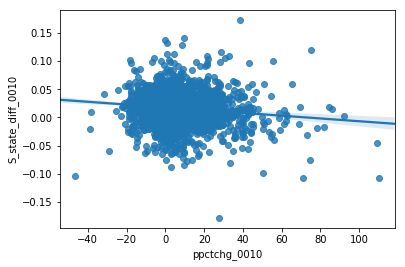

In [14]:
sns.regplot('ppctchg_0010', 'S_state_diff_0010', df)

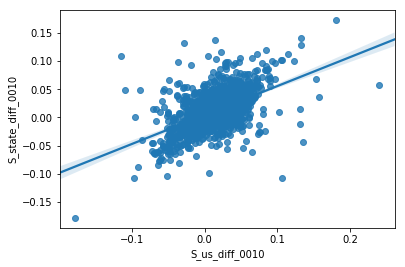

In [15]:
sns.regplot('S_us_diff_0010', 'S_state_diff_0010', df)

Text(0.5,1,u'2000-2010')

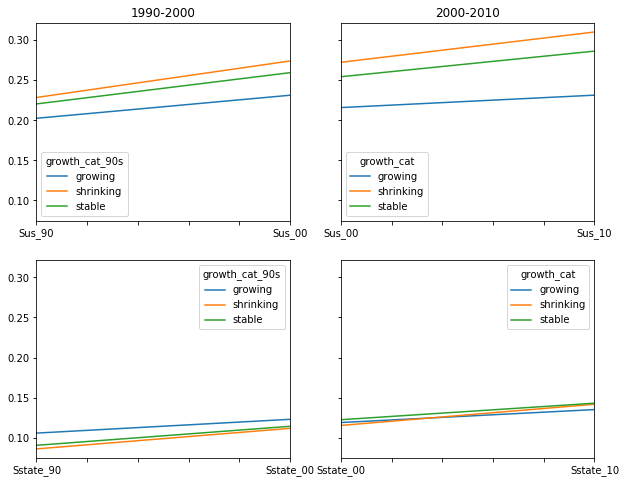

In [17]:
# plot change in median diversity across periods
# first row shows change in 4 group diversity
# second row shows change in 3 group diversity

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, sharey=True, figsize=(10,8))
cols1 = ['Sus_90', 'Sus_00']
cols2 = ['Sus_00', 'Sus_10']
df.groupby('growth_cat_90s')[cols1].median().transpose().plot(ax=ax1)
df.groupby('growth_cat')[cols2].median().transpose().plot(ax=ax2)
ax1.set_title('1990-2000')
ax2.set_title('2000-2010')

cols1 = ['Sstate_90', 'Sstate_00']
cols2 = ['Sstate_00', 'Sstate_10']
df.groupby('growth_cat_90s')[cols1].median().transpose().plot(ax=ax3)
df.groupby('growth_cat')[cols2].median().transpose().plot(ax=ax4)
ax1.set_title('1990-2000')
ax2.set_title('2000-2010')